# Convolutional Collaborative Filtering

In [1]:
import numpy as np

from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, LSTM, RepeatVector, Dense, Dropout
from keras.models import Model
import pandas as pd
import gensim
from string import punctuation
from collections import Counter
import tensorflow as tf
import os
import pickle

from model_cdl_conf_mf import Conv_CDL
#init random seed
np.random.seed(5)
from sklearn.model_selection import train_test_split
from matrix_factorization_with_als import MF
from model_out_utils import make_out_dirs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

Using TensorFlow backend.


In [2]:
# make useful dirs
XP_PATH, U_V_PATH, MODEL_PATH = make_out_dirs(model_name='conv_mf', xp_name='test1')
print("Out dir of experiment: ", XP_PATH)
print("Out dir of U, V matricies: ", U_V_PATH)
print("Out dir of model parameters: ", MODEL_PATH)

Out dir of experiment:  D:/Models/thesis/conv_mf/test1/
Out dir of U, V matricies:  D:/Models/thesis/conv_mf/test1/pickles/
Out dir of model parameters:  D:/Models/thesis/conv_mf/test1/tf/


### Load review texts

In [3]:
df = pd.read_json(r'D:\Datasets\amazon_reviews\processed\reviews_Video_Games_5.json')

In [4]:
print('Shape: %s x %s' % df.shape)

Shape: 231780 x 11


In [5]:
df_train, df_test = train_test_split(df, test_size = 0.3, stratify=df['reviewerID'], random_state=42)

In [6]:
print('Train shape: %s x %s' % df_train.shape)

Train shape: 162246 x 11


In [67]:
df_train.head(2)

,asin,helpful,overall,reviewText,reviewTextProc,reviewTime,reviewerID,reviewerName,summary,summaryProc,unixReviewTime
147833,B002WSR8CQ,"[0, 0]",4,I BROUGHT THIS GAME FOR MY SON AND HE LOVES IT...,i bring this game for my son and he love it th...,"01 7, 2011",A3P3XF9FS9AJCH,C. SESSIONS,VERY FUN,very fun,1294358400
95387,B000X1TC0U,"[4, 4]",5,"I'm very late to the party with this review, s...",i be late party review i will informal short i...,"01 20, 2009",A3KKM0T1KY42HA,Sky,Aliens,alien,1232409600


In [68]:
reviews = df_train.groupby('asin').reviewTextProc.agg(' '.join)
summaries = df_train.groupby('asin').summaryProc.agg(' '.join)

texts = reviews + ' ' + summaries 

In [69]:
texts.iloc[0][0:250]

'this pretty fun game buy car track online store the game claim provide content scam not content game you need buy if win race message say yay you purchase new car online store!!!"omg really i can spend more money on a game i already pay for no wai!!!'

In [70]:
print("Reviews shape: " , texts.shape)

Reviews shape:  (10668,)


### Tokenize reviews

In [71]:
tokenizer = Tokenizer() # nb_words=MAX_NB_WORDS
tokenizer.fit_on_texts(texts)
review_sequences = tokenizer.texts_to_sequences(texts)

In [72]:
print("Num of train texts: %s" % len(review_sequences))
print("Example of sequence: ", review_sequences[1][1:15], '...')

Num of train texts: 10668
Example of sequence:  [20, 147, 93, 9, 42, 88, 8735, 478, 361, 42, 2920, 395, 360, 169] ...


C:\Users\irina\Miniconda3\envs\exmc\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


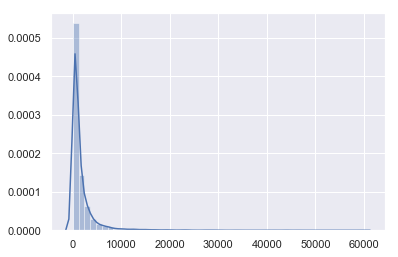

In [73]:
sns.distplot([len(s) for s in review_sequences])

In [78]:
padded_review_sequences = pad_sequences(review_sequences, maxlen=8000)

In [79]:
print('Shape of padded review Sequences: ', padded_review_sequences.shape)

Shape of padded review Sequences:  (10668, 8000)


In [80]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print('Indexes of common words: you = %s, the = %s, it = %s.' % (word_index['you'], word_index['the'], word_index['it']))

Found 162557 unique tokens.
Indexes of common words: you = 15, the = 3, it = 9.


In [81]:
sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[0:20]

[('game', 738389),
 ('i', 670739),
 ('the', 273644),
 ('be', 272470),
 ('not', 256432),
 ('play', 217593),
 ('good', 192337),
 ('like', 174719),
 ('it', 123779),
 ('time', 118928),
 ('great', 110834),
 ('this', 99196),
 ('fun', 98026),
 ("'s", 84273),
 ('you', 76444),
 ('get', 73928),
 ('character', 71603),
 ('have', 69465),
 ('new', 66894),
 ('buy', 64798)]

### Prepare embedding matrix

In [82]:
# Loading Word2Vec
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('D:/Datasets/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [83]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
missed_words = Counter()

for word, i in word_index.items():
    if word in w2v_model:
        embedding_matrix[i] = np.array(w2v_model[word])
    else:
        missed_words[word] += 1
        embedding_matrix[i] = np.random.rand(1, EMBEDDING_DIM)[0]

In [84]:
print(len(missed_words))
missed_words.most_common(20)

108712


[('chatper', 1),
 ('aaaaaah', 1),
 ('relytia', 1),
 ('looks3', 1),
 ('changeits', 1),
 ('factorin', 1),
 ('fation', 1),
 ('29mb', 1),
 ('5glitched', 1),
 ('factiondid', 1),
 ('anthropomorphically', 1),
 ('nocomplaint', 1),
 ('princericard', 1),
 ('becomesthe', 1),
 ('execelente', 1),
 ('starspace', 1),
 ('carnate', 1),
 ('yourtactical', 1),
 ('bartica', 1),
 ('efectiveness', 1)]

### Prepare matrix

In [85]:
pivoted = df_train.pivot(index = 'reviewerID', columns = 'asin', values = 'overall')
pivoted = pivoted.fillna(0.)

In [86]:
pivoted.head(5)

asin,0700099867,6050036071,7100027950,7293000936,8176503290,907843905X,9625990674,9861019731,9882155456,B000003SQQ,...,B00J128FPA,B00J226358,B00J6DLPLK,B00J9P3KBS,B00JM3R6M6,B00JQ8YH6A,B00JQHU9RC,B00JXW6GE0,B00KAI3KW2,B00KHECZXO
reviewerID,,,,,,,,,,,,,,,,,,,,,
A00263941WP7WCIL7AKWL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A005481137I9SCAWEF7ON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01588502N52TNG1BP7WG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01803182IUSFNIFF5984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A023090719X7MTBCLM19B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
rating_matrix = pivoted.values

In [88]:
texts.shape

(10668,)

In [89]:
pivoted.shape

(24303, 10668)

In [91]:
# chack that asins are the same
sum(texts.index == pivoted.columns)

10668

### Save all prepared matricies for later use

In [92]:
####### SAVE MATRICIES ########
with open(XP_PATH + 'embedding_mx.pickle', 'wb') as handle:
    pickle.dump(embedding_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(XP_PATH + 'pad_review_seqs.pickle', 'wb') as handle:
    pickle.dump(padded_review_sequences, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(XP_PATH + 'rating_matrix.pickle', 'wb') as handle:
    pickle.dump(rating_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Create model

### Train model

In [5]:
####### LOAD MATRICIES #######
with open(XP_PATH + 'embedding_mx.pickle', 'rb') as handle:
    embedding_matrix = pickle.load(handle)  
    embedding_matrix = embedding_matrix.astype(np.float32)
    
with open(XP_PATH + 'pad_review_seqs.pickle', 'rb') as handle:
    padded_review_sequences = pickle.load(handle)
    
with open(XP_PATH + 'rating_matrix.pickle', 'rb') as handle:
    rating_matrix = pickle.load(handle)

In [6]:
tf.reset_default_graph()

In [7]:
%%time
model = Conv_CDL(embed_matrix = embedding_matrix, texts = padded_review_sequences, rating_matrix=rating_matrix, epochs=100)

Shape of embed texts:  (?, 50)
Shape of V:  Tensor("Placeholder_1:0", shape=(?, 50), dtype=float32)
Trainable params
[TensorShape([Dimension(3), Dimension(300), Dimension(1), Dimension(50)]), TensorShape([Dimension(50)]), TensorShape([Dimension(4), Dimension(300), Dimension(1), Dimension(50)]), TensorShape([Dimension(50)]), TensorShape([Dimension(5), Dimension(300), Dimension(1), Dimension(50)]), TensorShape([Dimension(50)]), TensorShape([Dimension(150), Dimension(150)]), TensorShape([Dimension(150)]), TensorShape([Dimension(150), Dimension(50)]), TensorShape([Dimension(50)])]
Wall time: 1.42 s


In [8]:
%%time
U, V, beta_u, beta_v = model.training()

EPOCH 1 / 100: 
Initial embedding completed:  (10668, 50)
.

.........................

.........................

.........................

........
ALS LOSS 0.8890449077378076
REPR LOSS 304.04123
MODEL LOSS 391.62524
EPOCH 2 / 100: 
Initial embedding completed:  (10668, 50)
.

.........................

.........................

.........................

........
ALS LOSS 0.3353689786473879
REPR LOSS 222.3261
MODEL LOSS 308.6552
EPOCH 3 / 100: 
Initial embedding completed:  (10668, 50)
.

.........................

.........................

.........................

........
ALS LOSS 0.27682923146147553
REPR LOSS 194.07126
MODEL LOSS 279.4033
EPOCH 4 / 100: 
Initial embedding completed:  (10668, 50)
.

.........................

.........................

.........................

........
ALS LOSS 0.2450728287215461
REPR LOSS 178.70418
MODEL LOSS 263.1193
EPOCH 5 / 100: 
Initial embedding completed:  (10668, 50)
.

.........................

.........................

........

In [10]:
U, V, beta_u, beta_v = embed_reviews

In [11]:
## dump U and V matricies to pickle files
print("U shape: %s x %s" % U.shape)
print("V shape: %s x %s" % V.shape)

print("beta_u shape: %s" % beta_u.shape)
print("beta_v shape: %s" % beta_v.shape)

with open(U_V_PATH + 'U_final.pickle', 'wb') as handle:
    pickle.dump(U, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(U_V_PATH + 'V_final.pickle', 'wb') as handle:
    pickle.dump(V, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(U_V_PATH + 'beta_u_final.pickle', 'wb') as handle:
    pickle.dump(beta_u, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(U_V_PATH + 'beta_v_final.pickle', 'wb') as handle:
    pickle.dump(beta_v, handle, protocol=pickle.HIGHEST_PROTOCOL)

U shape: 24303 x 50
V shape: 10668 x 50
beta_u shape: 24303
beta_v shape: 10668
